(freqtrackpy)=

# Tracking mutations over time

```{note}
This section makes use of keyword-only arguments to `fwdpy11.evolvets`.
Many of those arguments are somewhat experimental in nature.
```

This recipe covers tracking the frequencies of all mutations over time during a simulation using a time series recorder.
Such tracking requires care, as it is not a common use case.
Internally, `fwdpy11` doesn't really care about how often each mutation is present in the population.
Usually, the simulation only needs to know if a mutation was removed by simplification, or remains somewhere in the ancestry of the population.
Therefore, to track frequencies, we need to work a little harder.

The following listing shows how we will track frequencies.
The key elements are:

* We initialize instances of the recorder with a "burn-in" time.
  We do not do anything until the population's generation is greater than that value.
  This check allows us to more quickly simulate to equilibrium, which we'll explain in more detail below.
* We record trajectories in a Python dictionary.
  The key will be tuples of `(origin time, position, effect size)`.
  The value will be the count of the mutation each generation.
* We take special care to not record the count of a fixation over and over again.

In [1]:
import typing
import attr
import fwdpy11


@attr.s(auto_attribs=True)
class PyFreqTracker(object):
    burnin_time: int
    trajectories: typing.Dict = attr.ib(default=attr.Factory(dict))

    def __call__(
        self, pop: fwdpy11.DiploidPopulation, sampler: fwdpy11.SampleRecorder
    ) -> None:
        if pop.generation > self.burnin_time:
            for c, m in zip(pop.mcounts, pop.mutations):
                if c > 0 and c <= 2 * pop.N:
                    k = (m.g, m.pos, m.s)
                    if k in self.trajectories:
                        # Make sure that we only record a fixation once.
                        if self.trajectories[k][-1] < 2 * pop.N:
                            self.trajectories[k].append(c)
                    else:
                        self.trajectories[k] = [c]

Now, let's simulate a model of a high rate of recurrent hitch-hiking:

In [2]:
pdict = {
    "nregions": [],
    "sregions": [fwdpy11.ExpS(beg=0, end=1, weight=1, mean=0.2)],
    "recregions": [fwdpy11.PoissonInterval(0, 1, 1e-2)],
    "gvalue": [fwdpy11.Multiplicative(2.0)],
    "rates": (0.0, 1e-3, None),
    "simlen": 100,
}
params = fwdpy11.ModelParams(**pdict)
pop = fwdpy11.DiploidPopulation(100, 1.0)
rng = fwdpy11.GSLrng(42)
recorder = PyFreqTracker(0)
fwdpy11.evolvets(
    rng,
    pop,
    params,
    10,
    recorder,
    track_mutation_counts=True,
    suppress_table_indexing=False,
)

The arguments to `fwdpy11.evolvets` need some explanation.
We simplify every 10 generations.
Setting `track_mutation_counts=True` tells the function to obtain mutation counts from diploid genomes every generation.
Setting `suppress_table_indexing=False` tells `fwdpy11` to index the tables after  every simplification event.
In generations when simplification occurs, mutation counts are obtained from trees and not from genomes.


```{note}
The current default behavior of `fwdpy11.evolvets` is to set `suppress_table_indexing=False`.
However, future releases will likely set that to `True`.
This recipe is written in anticipation of that change.
```

## Converting trajectories to data frames

We can easily do a lot of analysis from `recorder.trajectories`.
However, there are good reasons to convert things into common formats for analysis, such as the [pandas](https://pandas.pydata.org) data frame:

In [3]:
import typing

import numpy as np
import pandas as pd


def traj2df(trajectories: typing.Dict, N: int) -> pd.DataFrame:
    dfs = []
    for key, value in trajectories.items():
        df = pd.DataFrame(
            {
                "generation": np.arange(len(value), dtype=np.uint32) + key[0],
                "frequency": np.array(value) / (2 * N),
                "origin_time": [key[0]] * len(value),
                "position": [key[1]] * len(value),
                "effect_size": [key[2]] * len(value),
            }
        )
        dfs.append(df)
    return pd.concat(dfs)

## Plotting the  trajectories

Here is a function to plot all trajectories, eliminating those with sojourn times $< minlen$ generations.

In [4]:
import matplotlib.pyplot as plt

def plot_traj_df(
    df: pd.DataFrame, *, minlen: int, selected_alpha=1.0, neutral_alpha=1.0
) -> typing.Tuple:
    if minlen < 0:
        raise ValueError(f"minlen must be non-negative, got {minlen}")
    f, ax = plt.subplots()
    for n, g in df.groupby(["origin_time", "position", "effect_size"]):
        if len(g.index) >= minlen:
            if g.effect_size[0] == 0.0:
                ax.plot(g.generation, g.frequency, linestyle="--", alpha=neutral_alpha)
            else:
                ax.plot(g.generation, g.frequency, alpha=selected_alpha)
    ax.set_xlabel("Time (generation)")
    ax.set_ylabel("Frequency")

    return f, ax

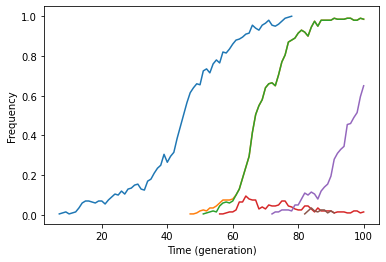

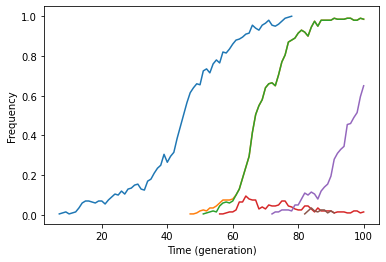

In [5]:
from myst_nb import glue

df = traj2df(recorder.trajectories, pop.N)
f, ax = plot_traj_df(df, minlen=10)
glue("pyfreqtrackfig", f, display=False)

```{glue:figure} pyfreqtrackfig
:name: 'pyfreqtrackfig'

Some sweeps from new mutations.
```

(freqtrackpy_neutral)=

## Tracking the frequencies of neutral mutations

One generally doesn't simulate neutral mutations.
However, certain questions regarding linked selection may force you to do so.
Neutral mutations *do not* get added to diploid genomes (in order to save memory), and thus will their counts are not obtained via `track_mutation_counts=True`.
The solution is:

* Simplify every generation, so that counts can be obtained from the trees.

In [6]:
pdict = {
    # Add a region for neutral mutations:
    "nregions": [fwdpy11.Region(0, 1, 1)],
    "sregions": [fwdpy11.ExpS(beg=0, end=1, weight=1, mean=0.2)],
    "recregions": [fwdpy11.PoissonInterval(0, 1, 1e-2)],
    "gvalue": [fwdpy11.Multiplicative(2.0)],
    # Add a mutation rate for neutral mutations:
    "rates": (5e-3, 1e-3, None),
    "simlen": 100,
}
params = fwdpy11.ModelParams(**pdict)
pop = fwdpy11.DiploidPopulation(100, 1.0)
rng = fwdpy11.GSLrng(54321)
recorder = PyFreqTracker(0)
fwdpy11.evolvets(
    rng,
    pop,
    params,
    1,  # Simplify every generation
    recorder,
    suppress_table_indexing=False,
)

Here, we do not need `track_mutation_counts=True` because simplifying each generation ends up accomplishing the same thing (for neutral and for selected variants).

Let's take a look at the plot.
We will reduce the opacity of selected variants to make the neutral ones pop a bit more:

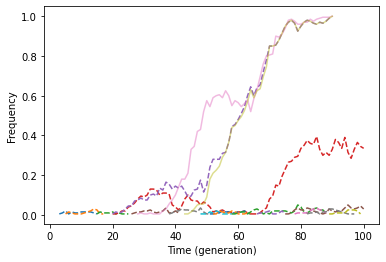

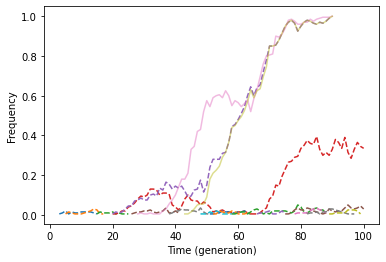

In [7]:
df = traj2df(recorder.trajectories, pop.N)
fn, ax = plot_traj_df(df, minlen=10, selected_alpha=0.50)
glue("pyfreqtrackfigneutral", fn, display=False)

```{glue:figure} pyfreqtrackfigneutral
:name: 'pyfreqtrackfigneutral'

The hitch-hiking effect.
Dotted lines show the trajectories of neutral mutations.
The selected variant trajectories have reduced opacity.
```

## Other considerations

This recipe needs adjustment for the following cases:

* Tracking mutation frequencies with respect to deme.
* Tracking mutation frequencies in demes that change size.

While this tracker is quite simple to write, performance may be an issue for very large simulations and one may prefer another approach.